### Preprocessing

In [1]:
import json
import re
import numpy as np

f = open('p6_data.json')
line = f.readline()
titles = []
locations = []
print ("loading tweets")

def match(l):
    if (re.match('.*WA.*', l) or re.match('.*Wash.*', l)):
        return 0
    if (re.match('.*MA.*', l) or re.match('.*Mass.*', l)):
        return 1
    return -1
        
count = 0
while len(line)!= 0:
    tweet = json.loads(line)
    location = tweet['location']
    match_result = match(location)
    if (match_result != -1):
        count += 1
        if (count % 5000 == 0):
            print (count)
        titles.append(tweet['title'])
        locations.append(match_result)
    line = f.readline()

num_titles = len(titles)
num_locations = len(locations)
print (num_titles)
print (num_locations)
print ("tweets loaded")
print (sum(locations))
print (num_locations - sum(locations))

loading tweets
5000
10000
15000
20000
25000
30000
32866
32866
tweets loaded


In [2]:
# from sklearn.model_selection import train_test_split # wrong
from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(titles, locations, test_size=0.1, random_state=0)

/Users/zhangyanming/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
print (len(y_test))
print (len(y_train))
print (len(X_train))
print (len(X_test))

3287
29579
29579
3287


In [4]:
print (y_test[:10])

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1]


In [5]:
from sklearn.feature_extraction import text
import re
import nltk 
import string
import numpy as np

from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag

stop_words = text.ENGLISH_STOP_WORDS
stemmer = SnowballStemmer("english")

def tokenizer_fun(text):
    new_text = re.sub(r'[^A-Za-z]', " ", text)
    new_text = re.sub("[,.-:/()?{}*$#&]"," ",new_text)  # remove all symbols
    new_text = "".join([ch for ch in new_text if ch not in string.punctuation])  # remove all punctuation
    new_text = "".join(ch for ch in new_text if ord(ch) < 128)  # remove all non-ascii characters
    new_text = new_text.lower() # convert to lowercase
    tokens =[word for sent in nltk.sent_tokenize(new_text) for word in nltk.word_tokenize(sent)]
    new_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            new_tokens.append(token)     
    stem = [stemmer.stem(t) for t in new_tokens]
    tagged_sent = pos_tag(stem)
    new_stem = [word for word,pos in tagged_sent if pos == 'NN'] # remove all non-noun words
    return new_stem

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Normalize features
# TODO: n_features need to tune
n_features = 100
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}', norm = 'l2', max_df=0.95, min_df=2, max_features=n_features)
TFxIDF_train = TFxIDF.fit_transform(X_train)
TFxIDF_test  = TFxIDF.transform(X_test)

In [41]:
print TFxIDF_train.shape
print TFxIDF_test.shape

(29579, 100)
(3287, 100)


In [42]:
from sklearn.decomposition import TruncatedSVD
n_components = 50
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
train_LSI = svd.fit_transform(TFxIDF_train)
test_LSI  = svd.transform(TFxIDF_test)

In [43]:
print (train_LSI.shape)
print (test_LSI.shape)

(29579, 50)
(3287, 50)


###  SVM classifier

In [10]:
from sklearn import svm
lin_svc = svm.LinearSVC()
lin_svc.fit(train_LSI, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [11]:
svm_predicted = lin_svc.predict(test_LSI)

/Users/zhangyanming/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


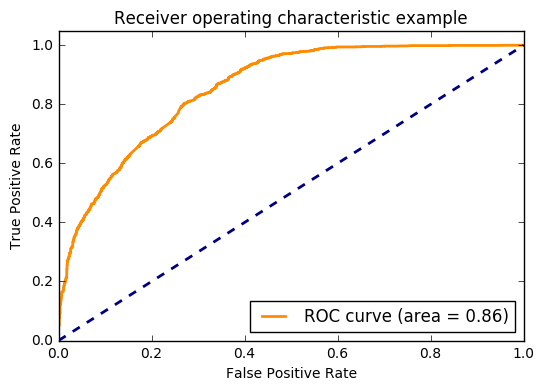

In [12]:
y_score_test = lin_svc.decision_function(test_LSI) # use decisioin_function to get better curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[ 952  596]
 [ 164 1575]]
Normalized confusion matrix
[[ 0.61  0.39]
 [ 0.09  0.91]]


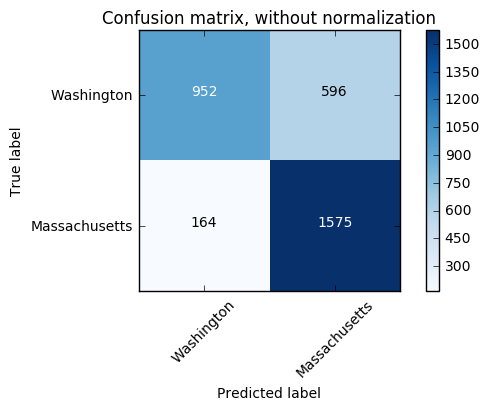

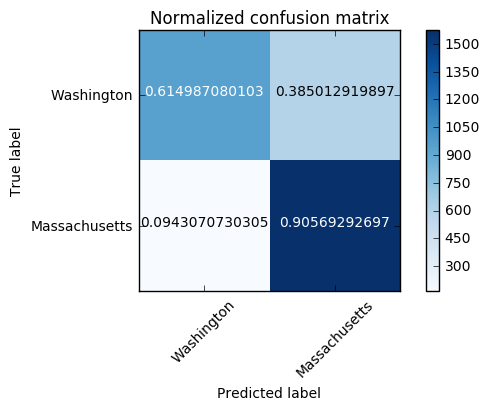

In [13]:
svm_predicted = lin_svc.predict(test_LSI)
from sklearn.metrics import confusion_matrix
import itertools
# TODO: W,M map to what ?
class_names = ['Washington', 'Massachusetts']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svm_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [14]:
from sklearn.metrics import accuracy_score
svm_accuracy = accuracy_score(y_test, svm_predicted)
print (svm_accuracy)

0.768786127168


In [15]:
from sklearn.metrics import recall_score
svm_recall_score = recall_score(y_test, svm_predicted)
print (svm_recall_score)

0.90569292697


In [16]:
from sklearn.metrics import precision_score
svm_precision_score = precision_score(y_test, svm_predicted)
print (svm_precision_score)

0.725472132658


### Soft Margin SVM

In [17]:
from sklearn.cross_validation import KFold
# TODO: can use all data rather than train data to find best para
kf = KFold(len(X_train), n_folds=5,shuffle=True,random_state=42)

In [18]:
print (len(X_train))
print (len(y_train))

29579
29579


In [19]:
# for train, test in kf:
#     print ("%s %s" % (train, test))

In [20]:
import numpy as np
y_train_array = np.array(y_train)
# y_test_array = np.array(y_test)

In [21]:
from sklearn import svm
matrix = [[0]*7 for i in range(5)]
i = 0
j = 0

for train_index, test_index in kf:
    X_train_s, X_test_s = train_LSI[train_index], train_LSI[test_index]
    y_train_s, y_test_s = y_train_array[train_index], y_train_array[test_index]
    for k in [-3, -2, -1, 0, 1, 2, 3]:
        soft_svm_clf = svm.LinearSVC(C=10**k)
        soft_svm_clf.fit(X_train_s, y_train_s)
        score = soft_svm_clf.score(X_test_s, y_test_s)
        matrix[i][j]=score
        j=j+1
    i=i+1
    j=0

In [22]:
# print (matrix)

In [23]:
avg_value = np.array(matrix)
print (avg_value.shape)

(5, 7)


In [24]:
max = 0
max_index = 0
for i in range (7):
    mean = np.mean(avg_value[:,i:i+1])
    if max < mean:
        max = mean
        max_index = i
print (max, max_index)
penalty = [-3, -2, -1, 0, 1, 2, 3]
best_penalty_para = penalty[max_index]
print (best_penalty_para)
print ("The best penalty value is %s" % 10**-best_penalty_para) 

(0.75868028419284461, 2)
-1
The best penalty value is 10


In [25]:
soft_svc = svm.LinearSVC(C=10**-best_penalty_para)
# soft_svc = svm.LinearSVC(C=10**-1)
soft_svc.fit(train_LSI, y_train)
soft_svc_predicted = soft_svc.predict(test_LSI)
score = soft_svc.score(test_LSI, y_test)
print ("The score with best penalty value is %s" % score)

The score with best penalty value is 0.768786127168


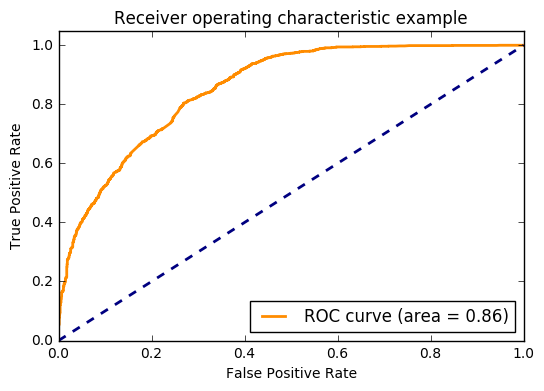

In [26]:
y_score_test = soft_svc.decision_function(test_LSI)
# print (soft_svc_predicted[:20]) #[1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0]
# print(y_score_test[:20])# [ 0.27 -0.48  0.41  0.34  0.12 -1.61 -1.44 -0.2   0.72  0.86  0.77  0.06 -1.19  0.22  0.36  0.05  0.57 -1.02  0.08 -0.51]
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[ 951  597]
 [ 163 1576]]
Normalized confusion matrix
[[ 0.61  0.39]
 [ 0.09  0.91]]


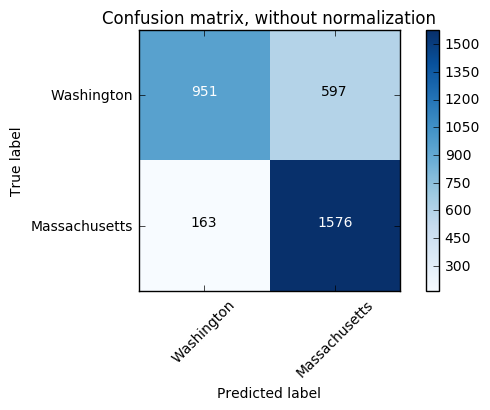

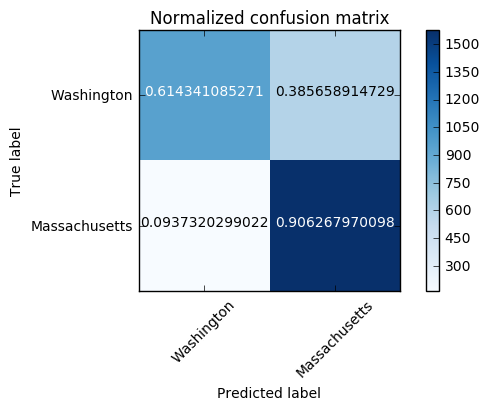

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, soft_svc_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
from sklearn.metrics import accuracy_score
soft_svc_accuracy = accuracy_score(y_test, soft_svc_predicted)
print (soft_svc_accuracy)

0.768786127168


In [29]:
from sklearn.metrics import recall_score
soft_svc_recall_score = recall_score(y_test, soft_svc_predicted)
print (soft_svc_recall_score)

0.906267970098


In [30]:
from sklearn.metrics import precision_score
soft_svc_precision_score = precision_score(y_test, soft_svc_predicted)
print (soft_svc_precision_score)

0.725264611137


### Naive Bayes algorithm

In [31]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#nb_clf = GaussianNB()
nb_clf = BernoulliNB() # a little better
nb_clf.fit(train_LSI, y_train)
nb_predicted = nb_clf.predict(test_LSI)

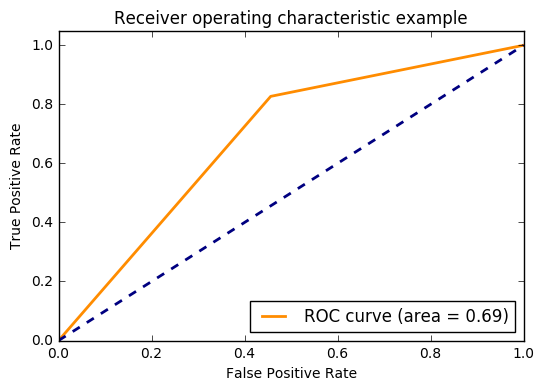

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, nb_predicted) # no decision function for Naive Bayes
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[ 842  706]
 [ 301 1438]]
Normalized confusion matrix
[[ 0.54  0.46]
 [ 0.17  0.83]]


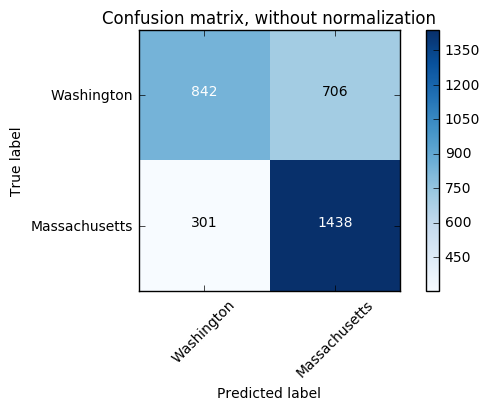

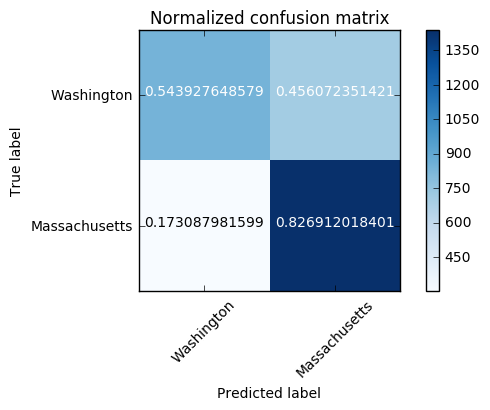

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, nb_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [34]:
from sklearn.metrics import accuracy_score
nb_accuracy = accuracy_score(y_test, nb_predicted)
print (nb_accuracy)

from sklearn.metrics import recall_score
nb_recall_score = recall_score(y_test, nb_predicted)
print (nb_recall_score)

from sklearn.metrics import precision_score
nb_precision_score = precision_score(y_test, nb_predicted)
print (nb_precision_score)

0.693641618497
0.826912018401
0.670708955224


## Logistic Regression

### I1

In [35]:
from sklearn import linear_model
lr_norm1 = linear_model.LogisticRegression(penalty = 'l1')
lr_norm1.fit(train_LSI, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

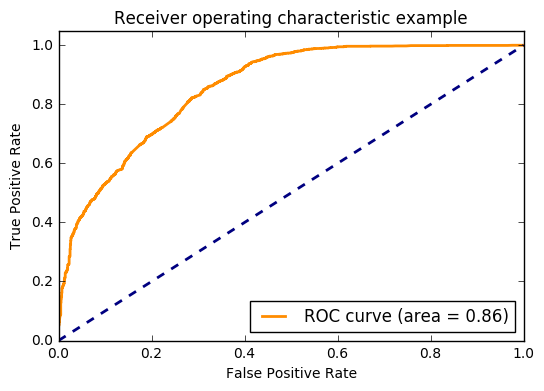

In [36]:
y_score_test_lr_norm1 = lr_norm1.decision_function(test_LSI)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_score_test_lr_norm1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[ 955  593]
 [ 159 1580]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.09  0.91]]


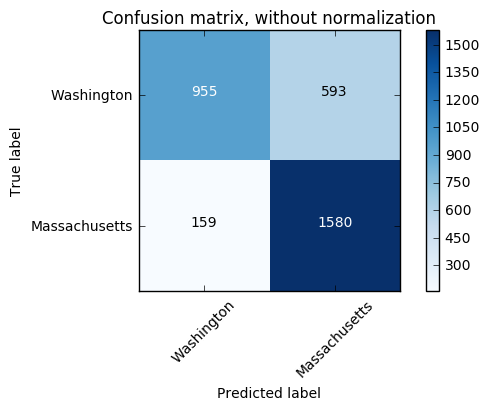

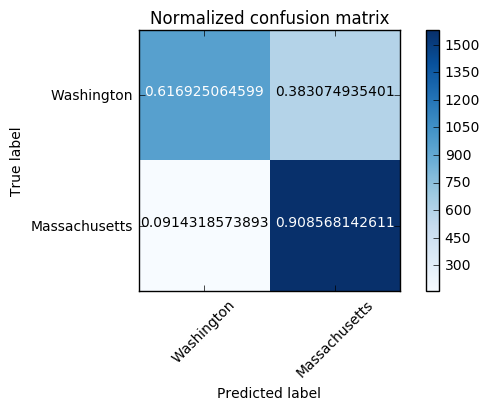

In [37]:
lr_norm1_predicted = lr_norm1.predict(test_LSI)
# class_names = ['Washington', 'Massachusetts']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lr_norm1_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [38]:
lr_norm1_accuracy = accuracy_score(y_test, lr_norm1_predicted)
print (lr_norm1_accuracy)

lr_norm1_recall_score = recall_score(y_test, lr_norm1_predicted)
print (lr_norm1_recall_score)

lr_norm1_precision_score = precision_score(y_test, lr_norm1_predicted)
print (lr_norm1_precision_score)

0.771219957408
0.908568142611
0.727105384261


### I2

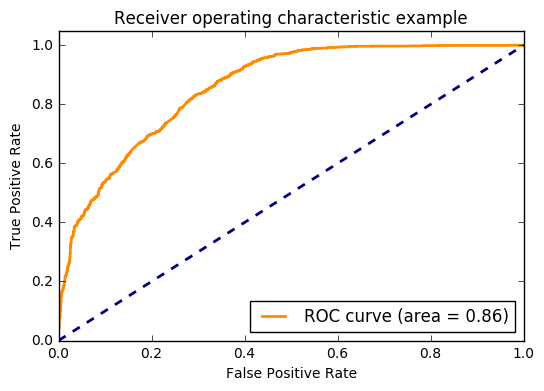

Confusion matrix, without normalization
[[ 957  591]
 [ 155 1584]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.09  0.91]]


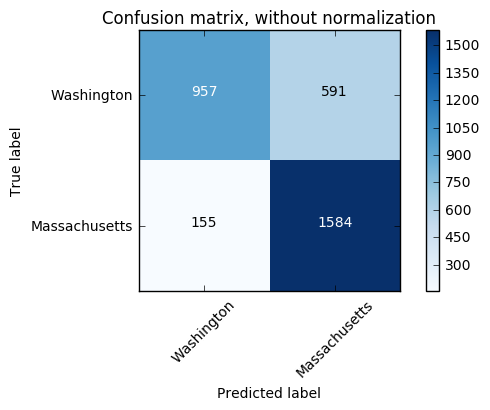

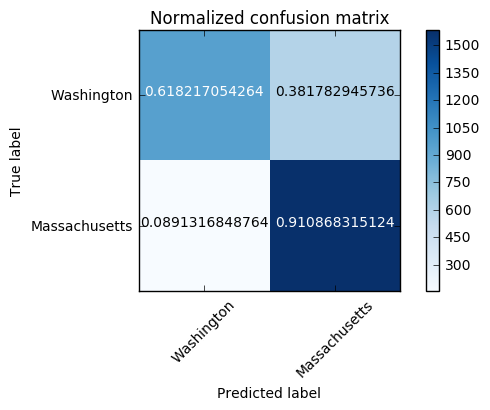

0.773045330088
0.910868315124
0.728275862069


In [39]:
lr_norm2 = linear_model.LogisticRegression() # default l2
lr_norm2.fit(train_LSI, y_train)

y_score_test_lr_norm2 = lr_norm2.decision_function(test_LSI)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_score_test_lr_norm2)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

lr_norm2_predicted = lr_norm2.predict(test_LSI)
# class_names = ['Washington', 'Massachusetts']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lr_norm2_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

lr_norm2_accuracy = accuracy_score(y_test, lr_norm2_predicted)
print (lr_norm2_accuracy)

lr_norm2_recall_score = recall_score(y_test, lr_norm2_predicted)
print (lr_norm2_recall_score)

lr_norm2_precision_score = precision_score(y_test, lr_norm2_predicted)
print (lr_norm2_precision_score)